In [1]:
# notebook has to be at the very top, then we switch back to inline
#%matplotlib notebook
%matplotlib inline

In [2]:
import pandas as pd 
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
#import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#from livelossplot import PlotLosses
#import time 
sys.path.append('../duq/')
  
# Importing the Bayesian LR module
import post, pre
import sgld
import mc_dropout

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppresses sklearn warning about PCA.. Is this ok?

Device =  cpu
Device =  cpu


In [3]:
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

# Importing Data

## Import full Dataset

In [4]:
# num_x, num_y, num_z, width_x, width_y, width_z, freq1, freq2, freq3, freq4, freq5, freq6, L2 dist
# [0]    [1]    [2]    [3]      [4]      [5]      [6]    [7]    [8]    [9]    [10]   [11]   [12]

y_cols = [6]             # Which column(s) does the the dependent variable(s) that we're interested in sit? list
x_cols = [0,1,2,3,4,5]   # Which column(s) is the independent variable(s) (features) in? list
component = "n/a"        # this is used if we want to sort and split the data by a particular parameter

# Import the csv file and save as DataFrame
filepath = '../data/all_data.csv'
#filepath = '../data/delet_me.csv'
df_orig = pd.read_csv(filepath, header=None)
df_orig.columns = ['nbays_x', 'nbays_y', 'nbays_z', 'bay_width_x', 'bay_width_y', 'bay_width_z', 'modal_freq_1', 'modal_freq_2', 'modal_freq_3', 'modal_freq_4', 'modal_freq_5', 'modal_freq_6']

data_mean = df_orig.mean()
data_std = df_orig.std()

# Visualise full dataset in reduced dimensional space 
_, components = post.PCA_transformdata(df_orig.iloc[:,x_cols], return_components=True)

## Split Data into Test, Train, Val

OOD lower:	835
OOD upper:	195
Train:		929
Test:		863
Val:		104
Unused:		82
Total:		1978 (of 1978)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


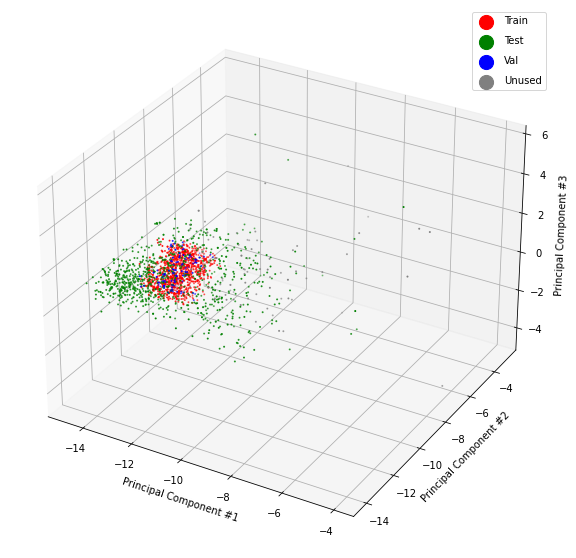

In [5]:
ood_lims_in = [[0., 3.], [0., 3.], [0., 3.], [0., 5.], [0., 5.], [0., 5.]]
train_lims_all = [[3., 10], [3., 10], [3., 10], [5., 10], [5., 10], [5., 10]]
ood_lims_out = [[10, 25], [10, 25], [10, 30], [10, 12], [10, 12], [10, 12]]

TRAIN, VAL, TEST = pre.split_by_bounds(df=df_orig,
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 train_lims_all=train_lims_all,
                                 ood_lims_in=ood_lims_in,
                                 ood_lims_out=ood_lims_out,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=True,
                                 plots=True,
                                 figsize=(10,10),
                                      save_image=True, savename="../reports/final_report_images/splitting_data/manual_bounds.eps", saveformat="eps")

x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

y_train_unnorm = pre.unnormalise(y_train,data_mean[y_cols].values,data_std[y_cols].values)
y_val_unnorm = pre.unnormalise(y_val,data_mean[y_cols].values,data_std[y_cols].values)
y_test_unnorm = pre.unnormalise(y_test,data_mean[y_cols].values,data_std[y_cols].values)


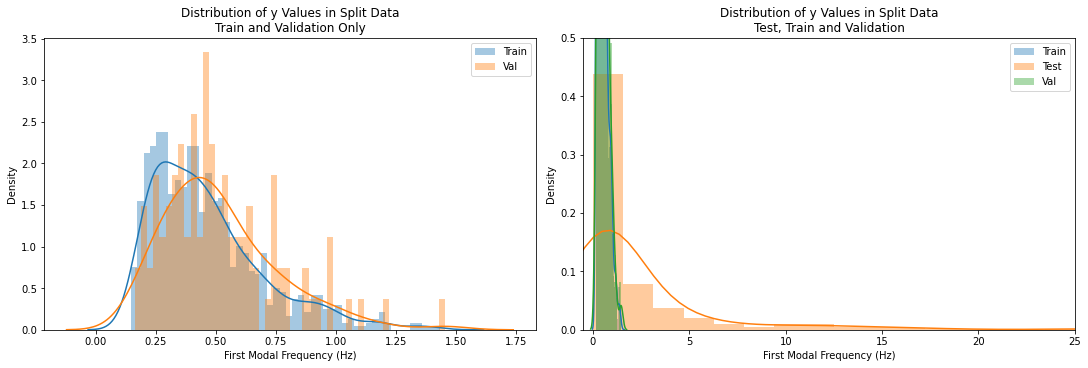

In [6]:
fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(15,5))

sns.distplot(y_train_unnorm,bins=50,label="Train",ax=axs[0])
sns.distplot(y_val_unnorm,bins=50,label="Val",ax=axs[0])
axs[0].set_title("Distribution of y Values in Split Data\nTrain and Validation Only")
axs[0].set_xlabel("First Modal Frequency (Hz)")
axs[0].legend()

sns.distplot(y_train_unnorm,label="Train",ax=axs[1])
sns.distplot(y_test_unnorm,label="Test",ax=axs[1])
sns.distplot(y_val_unnorm,label="Val",ax=axs[1])
axs[1].set_title("Distribution of y Values in Split Data\nTest, Train and Validation")
axs[1].set_xlabel("First Modal Frequency (Hz)")
axs[1].set_ylim((0,0.5))
axs[1].set_xlim((-0.5,25))
axs[1].legend();

# Neural Network Instantiation and Training

## Define Parameters of the Model

In [40]:
# Define the wandb parameters

savename = "../trained_models/for_prediction/MC_35"

parameters = dict(
    # Specific to this method
    drop_prob=0.3,
    num_samples=150,
    
    # Generic Hyperparameters
    num_epochs= 1000,
    batch_size= 50,#len(train_data), # Batch size for training data
    lr=  1e-6,                   # Learning rate
    weight_decay= None,#5,          # Weight decay
    
    # Model architecture
    input_dim= len(x_cols),      # Number of input neurons
    output_dim= len(y_cols),     # Number of output neurons
    num_units= 100,              # Number of neurons per hidden layer
    num_layers=5,
    
    # Data
    y_cols = y_cols,             # Which column(s) contain the dependent variable(s) / label(s) 
    x_cols = x_cols,             # Which column(s) contain the independent variable(s) / feature(s)
    
    # Logigng only
    component = None,       # Which parameter are we sorting by (as an int)? 
    sortby=None,       # Name of the component we're sorting by (as a string)
    model_name= "MC_Uncertanalysis",    # For logging only
    criterion_name= "MSELoss",   # For logging only
    optimiser_name= "Adam",      # For logging only 
    cutoff_percentile = None,  # How much we're splitting from top and bottom of sorted training set for test set 
    val_split=None,         # How much we're splitting from the train set (minus the test set), as a float between 0-1
    seed=seed,                   # Random seed used (for logging only)
    ood_lims_in=ood_lims_in, 
    train_lims_all=train_lims_all, 
    ood_lims_out=ood_lims_out 
)

assert parameters['output_dim'] == len(y_cols), f"Please ensure that the number of output neurons is correct! There should be {len(y_cols)}"
assert parameters['input_dim'] == len(x_cols), f"Please ensure that the number of input neurons is correct! There should be {len(x_cols)}" 

## If using Weights and Biases API, Log In

In [41]:
# Whether or not to log the run to Weights and Biases (https://wandb.ai/home). Requires an account
wandb_mode = True

if wandb_mode: 
    import wandb
    wandb.login()
    wandb.init(config=parameters, entity="archieluxton", project=parameters['model_name'])

## Instantiate the Model Class

In [42]:
# Instantiate a model class of type MC Dropout
model = mc_dropout.MC_Dropout(train_data = train_data,
                              parameters=parameters, 
                              val_data=val_data,
                              data_mean=data_mean,
                              data_std=data_std,
                              wandb_mode=wandb_mode)

## Train the Model

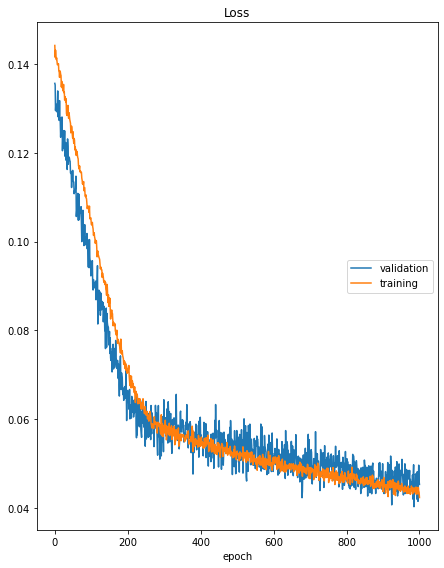

Loss
	validation       	 (min:    0.040, max:    0.136, cur:    0.045)
	training         	 (min:    0.042, max:    0.144, cur:    0.042)
Time elapsed: 61.18s.
Number of trainable model parameters: 31101, number of training samples: 929
Used batches of 50.



In [43]:
%matplotlib inline
net = model.train_model(LLP=True)

# Perform Forward Passes for each Dataset

In [44]:
# This creates samples, mean predictions, standard deviations and true y values for each data set
# If we only have one output neuron, samples is a Tensor of shape (#samples, #datapoints)
# If we have more than one output neuron, samples is Tensor of shape (#outputs, #samples, #datapoints)

samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)

***
***
# Post-Processing and Visualisation

## Plot the Uncertainty of Each Datapoint (Train, Test and Val)
### Error Bar Plot

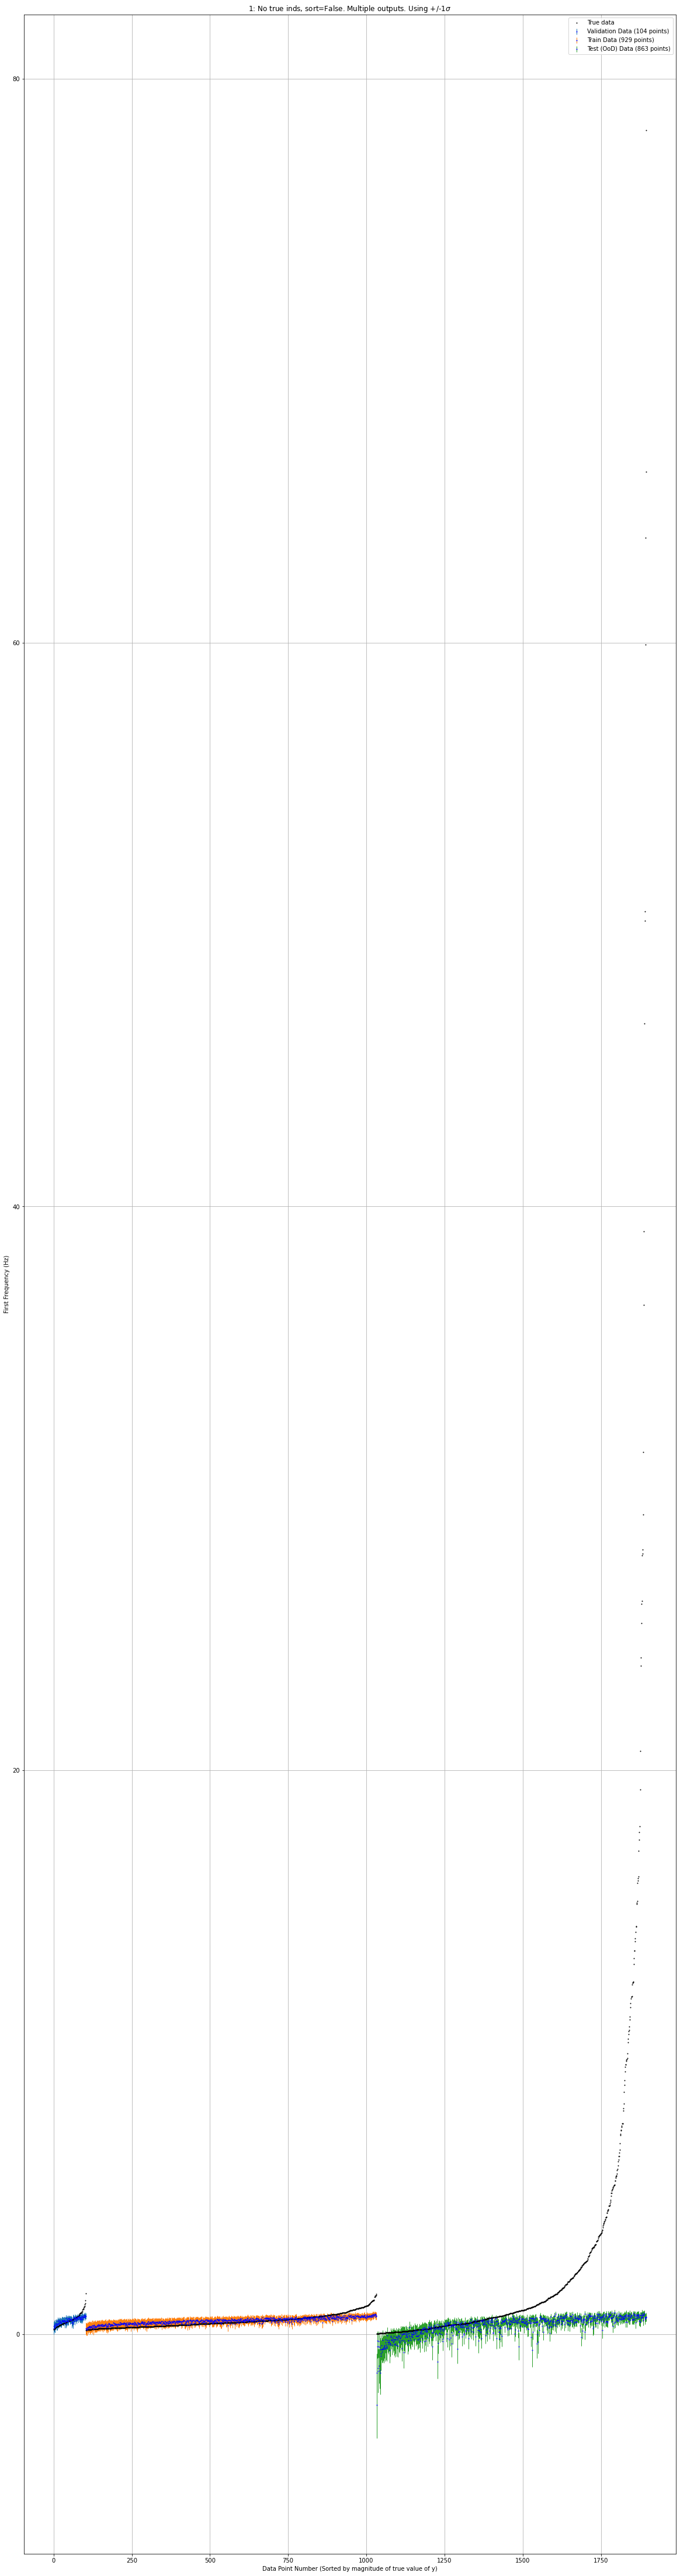

In [45]:
%matplotlib inline
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2", "freq3"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = component,
             sort=True,
             sortby="0",
             bar_method="bars",
             title="1: No true inds, sort=False. Multiple outputs",
             ylabel="First Frequency (Hz)",
             figsize=(20,80))
             #ylim=(0,1.5))
    
#if wandb_mode: wandb.log({"Errorbars":wandb.Image(uncert_plot)})

## Show the Distribution of Errors and Uncertainties in each Dataset
### Find how many points we're not sure about

In [46]:
err_train = post.count_wrong_preds(samples_train, y_train_np, 1, "SD", False)
err_test = post.count_wrong_preds(samples_test, y_test_np, 1, "SD", False)
err_val = post.count_wrong_preds(samples_val, y_val_np, 1, "SD", False)

if wandb_mode: 
    wandb.log({"Err_train":np.sum(err_train)})
    wandb.log({"Err_test":np.sum(err_test)})
    wandb.log({"Err_val":np.sum(err_val)})
    

print(f"Train error:\t{np.sum(err_train)}\t(low: {err_train[0]}, high: {err_train[1]})")
print(f"Test error:\t{np.sum(err_test)}\t(low: {err_test[0]}, high: {err_test[1]})")
print(f"Val error:\t{np.sum(err_val)}\t(low: {err_val[0]}, high: {err_val[1]})")
print("----------------------")
print(f"Total error:\t{np.sum(err_train)+np.sum(err_test)+np.sum(err_val)}")

Train error:	274	(low: 147, high: 127)
Test error:	585	(low: 584, high: 1)
Val error:	29	(low: 20, high: 9)
----------------------
Total error:	888


### Using Histograms

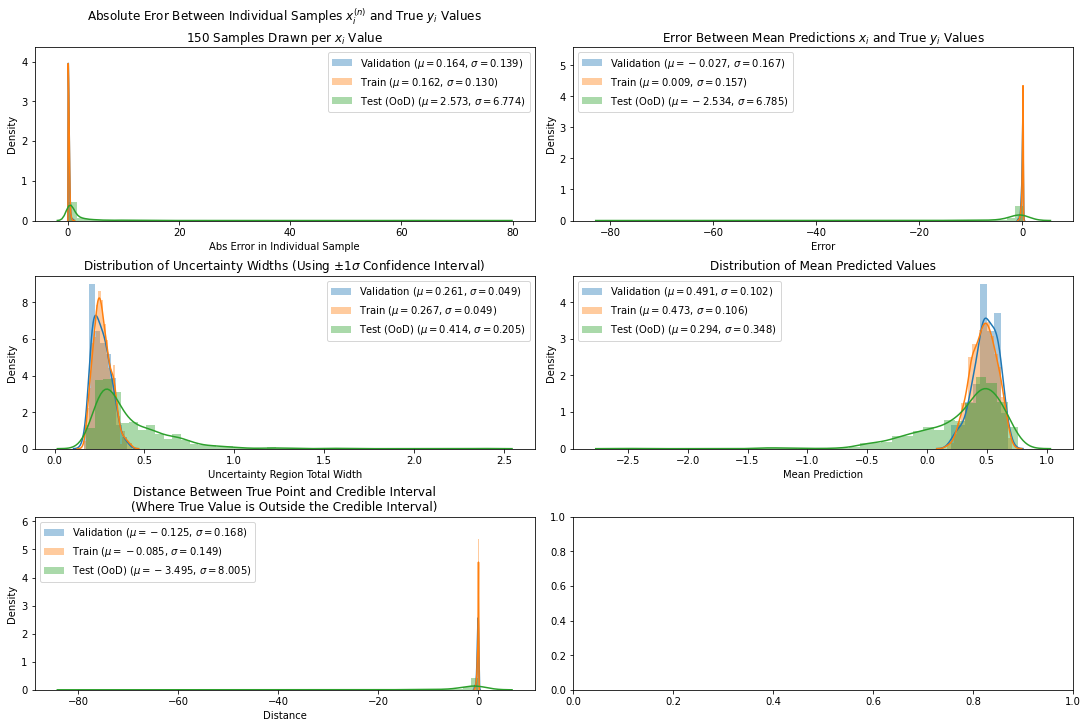

In [47]:
%matplotlib inline
samples = [samples_val, samples_train, samples_test]
true = [y_val_np, y_train_np, y_test_np]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples, true, labels, method="SD", interval=1, dp=.3)

# Save the image to weights and biases
if wandb_mode: wandb.log({"Histograms_output0":wandb.Image(histograms1)})
if wandb_mode: wandb.log({"Data_output0":statistics1})
    
# Print the individual figures shown in the histograms
# import json
# print(json.dumps(statistics1, indent=6, default=str))

### Using Prinicpal Component Analysis in 3D

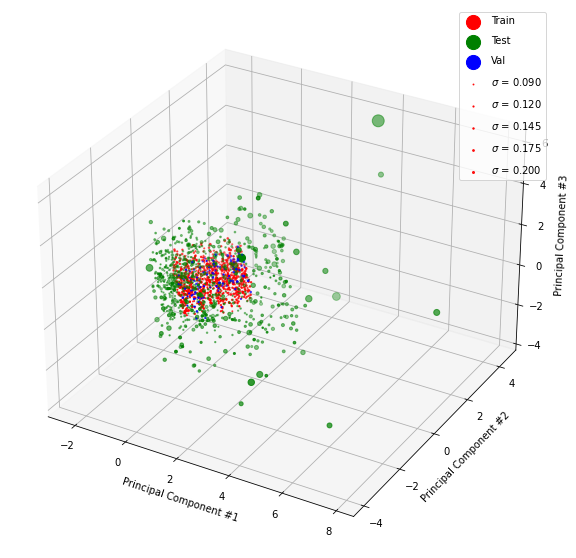

In [48]:
x_train_PCA, components = post.PCA_transformdata(x_train, return_components=True)
x_test_PCA = post.PCA_transformdata(x_test, components=components)
x_val_PCA = post.PCA_transformdata(x_val, components=components)


plot = post.PCA_plot([x_train_PCA, x_test_PCA, x_val_PCA], 
                  [stds_train, stds_test, stds_val],
                   labels=["Train", "Test", "Val"],
                   output_num= 0,
                   figsize=(10,10),
                   scalingfactor=10,
                   scalingpower=2,
                   produce_animation=False,
                   legend_num=5,
                   legend_HDI=0.99)

if wandb_mode: wandb.log({"PCA_Uncert":wandb.Image(plot)})

In [49]:
if wandb_mode: wandb.finish()

Err_test,▁
Err_train,▁
Err_val,▁
loss,█▇▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Err_test,585
Err_train,274
Err_val,29
loss,0.04233
val_loss,0.04528


In [50]:
torch.save(model, savename)